In [794]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager
import json
import time
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

In [795]:
def coeff(arr):#Fourier Coeff of fft
    A = []
    l = len(arr)
    for i in range(len(arr)):
        a = np.real((arr[i+1] + arr[l-i])/l)
        b = -np.imag((arr[i+1] - arr[l-i])/l)
        A.append([a, b])
    return np.asarray(A)

In [796]:
def fourier(v, nhar):#FFT with output coeff a_k, b_k
    npts    = len(v)
    f       = 2.0/npts
    t       = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    vmn     = np.mean(v)
    v       = v - vmn
    cofs    = [0]*(nhar+1)
    cofs[0] = (vmn,0)
    for i in range(1,nhar+1):
        c, s    = np.cos(i*t), np.sin(i*t)
        cofs[i] = (np.dot(v,c)*f, np.dot(v,s)*f)
    return (cofs)

def fourier_synth(cofs, npts):
    nt  = len(cofs)
    syn = np.zeros(npts)
    t  = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    for n in range(1, nt):
        for j in range(npts):
            syn[j] += cofs[n][0]*np.cos(n*t[j]) + cofs[n][1]*np.sin(n*t[j])
    return (syn)


In [797]:
def get_data(df, n): 
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    for i in tqdm(range(n)):     
        driver.get(url)
        l = driver.find_element(By.XPATH, "/html/body/pre[1]")
        temp_json = json.loads(l.text)
        
        df = df.append(pd.json_normalize(temp_json))
        #print('total data = ', df.size)
        df = df.drop_duplicates(subset=['time_tag'])
        #print('total data = ', df.size)
        df.to_csv('geomag.csv', encoding='utf-8', index=False)
        if i != n-1:
            time.sleep(60)
    driver.close()
    return df

In [801]:
df = pd.read_csv('geomag.csv', encoding = 'utf-8')
df = get_data(df, 2)

100%|██████████| 2/2 [01:02<00:00, 31.10s/it]


In [802]:
df

,time_tag,satellite,He,Hp,Hn,total,arcjet_flag
0,2024-08-17T00:00:00Z,16,47.149677,85.845406,-6.825669,98.179092,False
1,2024-08-17T00:01:00Z,16,47.104980,85.798729,-6.739515,98.110847,False
2,2024-08-17T00:02:00Z,16,47.165562,85.738754,-6.693605,98.084381,False
3,2024-08-17T00:03:00Z,16,47.196194,85.546448,-6.680991,97.930191,False
4,2024-08-17T00:04:00Z,16,47.319283,85.564995,-6.670309,98.005028,False
...,...,...,...,...,...,...,...
1434,2024-08-19T13:32:00Z,16,27.174784,93.436378,2.412379,97.338234,True
1435,2024-08-19T13:33:00Z,16,26.754793,93.404579,2.813163,97.202011,True
1436,2024-08-19T13:34:00Z,16,26.826408,93.043861,2.516447,96.866989,True
1437,2024-08-19T13:35:00Z,16,26.343796,93.096474,2.456589,96.783409,True


In [803]:
t_format = '%Y-%m-%dT%H:%M:%SZ'
t_tag =[datetime.strptime(i, t_format)for i in df['time_tag']]
He = np.asarray([i for i in df['He']])
Hp = np.asarray([i for i in df['Hp']])
Hn = np.asarray([i for i in df['Hn']])

t = np.arange(1, len(He)+ 1)

H_e = He
H_p = Hp
H_n = Hn


In [929]:
def split_daytag(tag):
    D_split = []
    for i in range(len(tag)//1440):
        D_split.append(tag[i*1440:1440*(i+1)])
    return D_split

In [930]:
def splitday(H):#list 1440/day
    H_split = []
    for i in range(len(H)//1440):
        H_split.append(H[i*1440:1440*(i+1)]-H[i*1440:1440*(i+1)].mean())
    return H_split

In [931]:
def cofs(H):#calculate x and x_cofs, return x, syn_x
    day = len(H)
    tmp, tmp_syn = [], []
    for i in range(day):
        x = H[i]
        x_cofs = fourier(x, 3)
        syn_x = fourier_synth(x_cofs, 1440)
        tmp.append(x)
        tmp_syn.append(syn_x)
    return np.asarray(tmp), np.asarray(tmp_syn)

In [973]:
def plot_kp(H, tag):
    day = len(H)
    minX = []
    maxX = []
    x, xsyn = cofs(H)
    k_nT = []
    t = []
    for i in range(day):

        diff = (np.asarray(x[i])-np.asarray(xsyn[i]))
        diff = diff.reshape(8, 180)

        
        minX.append(np.min(diff, axis = 1))
        maxX.append(np.max(diff, axis = 1))
        k_nT.append(np.asarray(maxX[i]) - np.asarray(minX[i]))
        t.append(tag[i][::180])
        
    kp = np.digitize(k_nT, bins = k_scale)
    
    fig, axes = plt.subplots(2, 1, figsize = [24, 20], sharex = True)

    for i in range(day):
        axes[0].plot(tag[i],x[i], color = 'tab:blue', alpha = 0.8)
        axes[0].plot(tag[i], xsyn[i], color = 'tab:red', alpha = 0.8)
        axes[1].bar(t[i], kp[i], width = 0.1, color = 'tab:green', align = 'edge')

    for i in axes:
        i.grid(True)
        #i.legend()
        i.xaxis.set_major_locator(mdates.DayLocator(bymonthday = range(1,32)))
        i.xaxis.set_minor_locator(mdates.HourLocator(byhour =range(24)[::3]))
        i.set_xlabel('Date & Time (UT)')
    


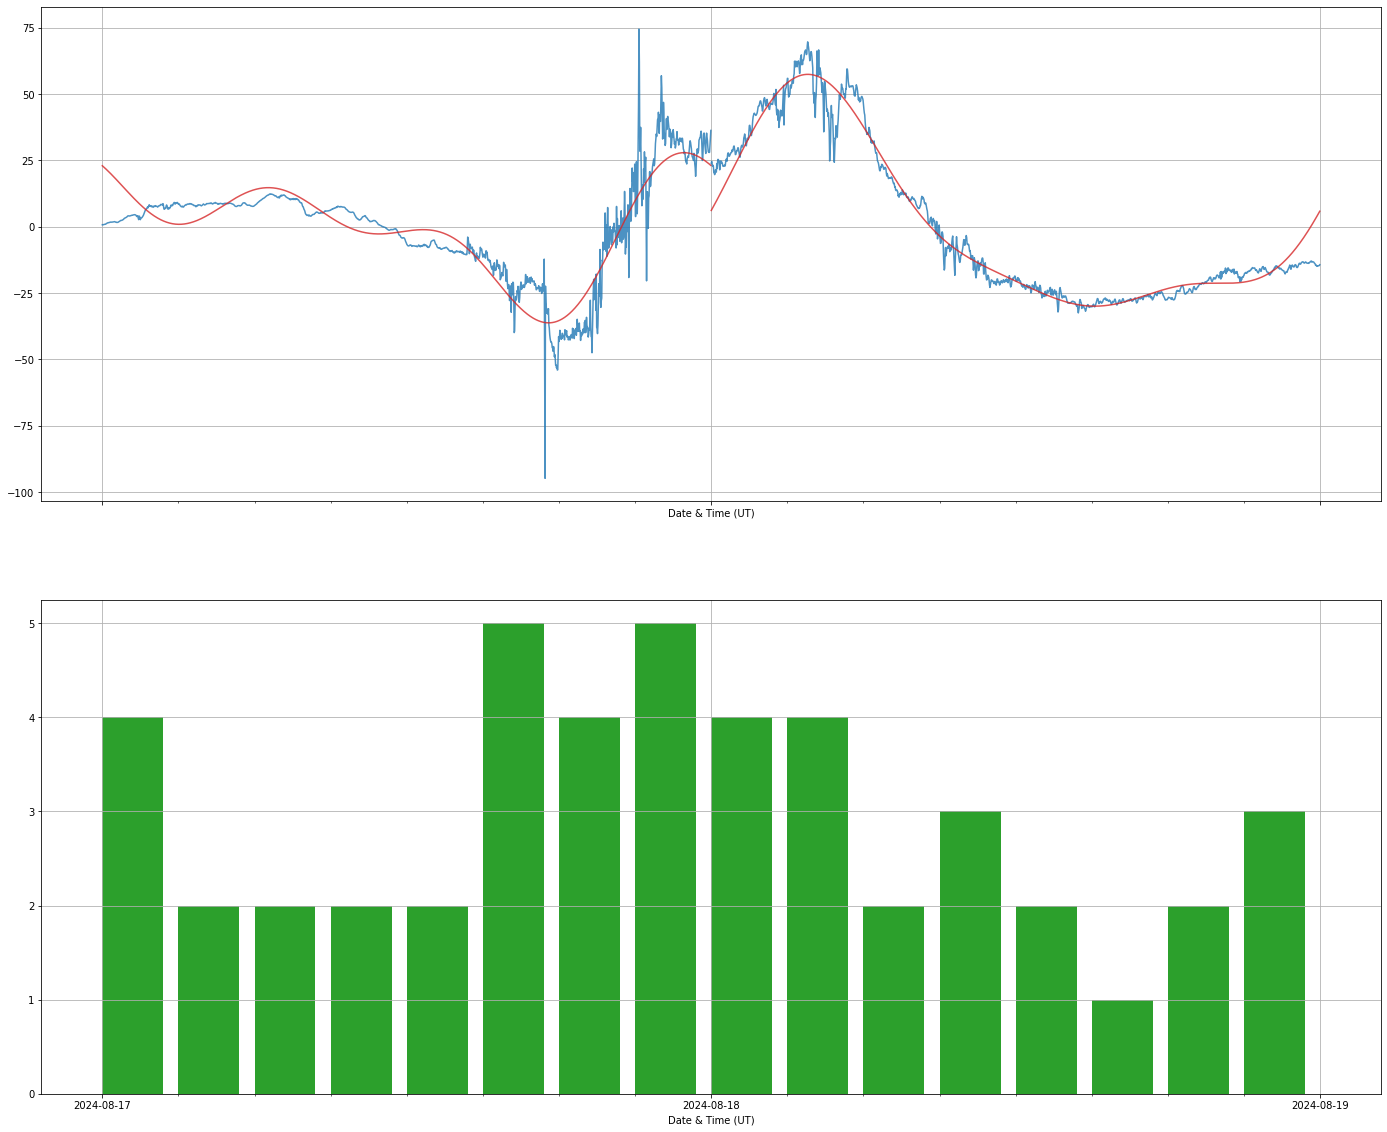

In [974]:
He = splitday(H_e)
tag = split_daytag(t_tag)
plot_kp(He, tag)

In [723]:
k_scale = [0, 8, 15, 30, 60, 105, 180, 300, 500, 750]

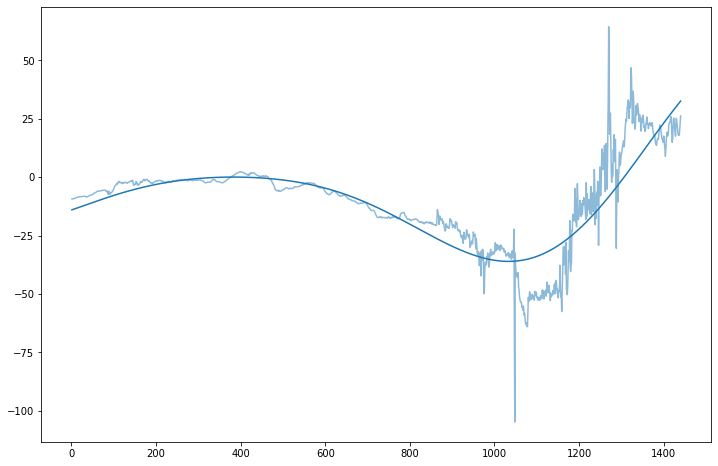

In [724]:
plt.figure(figsize = [12, 8])

x = He[:day*1440]
plt.plot(t[:day*1440], x, color = 'tab:blue', alpha = 0.5)

He_cofs = fourier(He, 3)#3 because assume the S_R aka solar regular variation made up with 24h/12h/8h signals
syn_He  = fourier_synth(He_cofs, len(He))

x = He[:day*1440]
synx = syn_He[:day*1440]

plt.plot(t[:day*1440], synx, color = 'tab:blue')

#for i, time in enumerate(t):
#    plt.plot(t[i], He[i], color = 'tab:blue')
#    plt.fill_between(t[i], min(He[i]),max(He[i]), alpha = 0.5, color = 'tab:red')
#    for j in range(len(He[i])):

#minX = np.min(np.array_split(He-syn_He, 8), axis=1)
#maxX = np.max(np.array_split(He-syn_He, 8), axis=1)
t_3hours = np.linspace(0, day*1440, 8*day+1, endpoint=True)
minX = np.min((x-synx).reshape(8*day, 180), axis=1)
maxX = np.max((x-synx).reshape(8*day, 180), axis=1)

#plt.fill_between(t_3hours, list(minX)+[0], list(maxX)+[0], step="post", color="tab:blue", alpha=0.5)
k_nT = maxX-minX
k_kp = np.digitize(k_nT, bins = k_scale)



In [725]:
t_tag
t_3hourstag = t_tag[::180]
t_3hourstag

[datetime.datetime(2024, 8, 17, 0, 0),
 datetime.datetime(2024, 8, 17, 3, 0),
 datetime.datetime(2024, 8, 17, 6, 0),
 datetime.datetime(2024, 8, 17, 9, 0),
 datetime.datetime(2024, 8, 17, 12, 0),
 datetime.datetime(2024, 8, 17, 15, 0),
 datetime.datetime(2024, 8, 17, 18, 0),
 datetime.datetime(2024, 8, 17, 21, 0),
 datetime.datetime(2024, 8, 18, 0, 0),
 datetime.datetime(2024, 8, 18, 3, 0),
 datetime.datetime(2024, 8, 18, 6, 0),
 datetime.datetime(2024, 8, 18, 9, 0),
 datetime.datetime(2024, 8, 18, 12, 0),
 datetime.datetime(2024, 8, 18, 15, 0)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


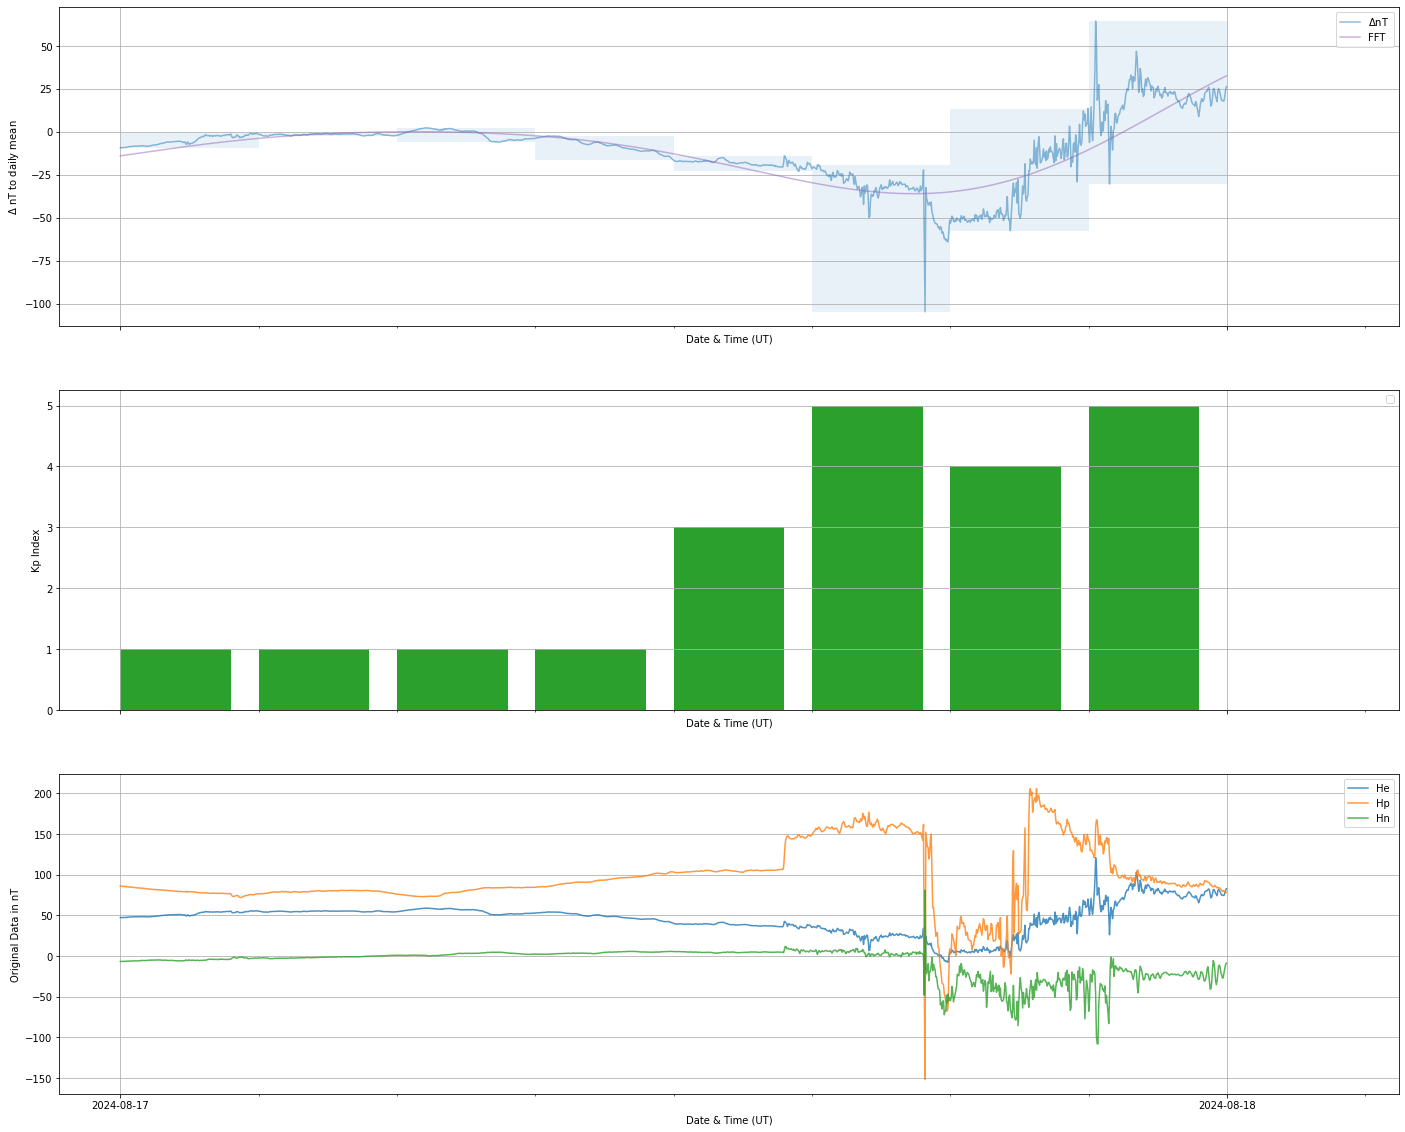

In [762]:
fig, axes = plt.subplots(3,1, figsize = [24, 20], sharex = True)

step_x = np.reshape(x, (day*8, 180))

axes[0].plot(t_tag[:day*1440], x, color = 'tab:blue', alpha = 0.5, label = '$\Delta$nT')
axes[0].plot(t_tag[:day*1440], synx, color = 'tab:purple', alpha = 0.5, label = 'FFT')
axes[0].fill_between(t_3hourstag[:day*8+1], list(np.min(step_x, axis = 1))+[0] , list(np.max(step_x, axis = 1))+[0] , step = 'post', alpha = 0.1)

axes[1].bar(t_3hourstag[:day*8+1],list(k_kp)+[0], width = 0.1 ,color = 'tab:green', align = 'edge') 

axes[2].plot(t_tag[:day*1440], H_e[:day*1440], alpha = 0.8, label = 'He')
axes[2].plot(t_tag[:day*1440], H_p[:day*1440], alpha = 0.8, label = 'Hp')
axes[2].plot(t_tag[:day*1440], H_n[:day*1440], alpha = 0.8, label = 'Hn')


#axes[0].grid(True)
#axes[1].grid(True)
#axes[2].grid(True)

#axes[0].xaxis.set_major_locator(mdates.DayLocator(bymonthday = range(1,32)))
#axes[0].xaxis.set_minor_locator(mdates.HourLocator(byhour =range(24)[::3]))

axes[0].set_ylabel('$\Delta$ nT to daily mean')
axes[1].set_ylabel('Kp Index')
axes[2].set_ylabel('Original Data in nT')



for i in axes:
    i.grid(True)
    i.legend()
    i.xaxis.set_major_locator(mdates.DayLocator(bymonthday = range(1,32)))
    i.xaxis.set_minor_locator(mdates.HourLocator(byhour =range(24)[::3]))
    i.set_xlabel('Date & Time (UT)')

